In [231]:
from pathlib import Path
Path.cwd()

WindowsPath('G:/我的文件/重庆大学/小项目/工业缺陷检测作业')

In [232]:
# 在 Jupyter 里建议第一格先写这个
import os
import glob
import cv2              # OpenCV，用来读图、处理图像
import matplotlib.pyplot as plt  # 用来在 notebook 里显示图片
import numpy as np
# 这句保证在 notebook 里直接显示图
%matplotlib inline

In [233]:
img_dir = r"./stainimg" 
# 支持的图片后缀，可以按需增删
ext = "*.bmp"
# 收集所有图片路径到一个列表里
img_paths = []
img_paths.extend(glob.glob(os.path.join(img_dir, ext)))
# 可以排序一下，方便查看
img_paths = sorted(img_paths)
print(f"在文件夹 {img_dir} 中共找到 {len(img_paths)} 张图片")


在文件夹 ./stainimg 中共找到 36 张图片


第一张图片路径： ./stainimg\cam2_20230303225959586.bmp


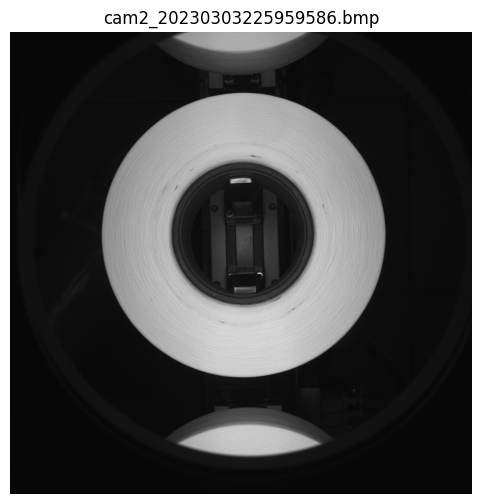

In [234]:
first_img_path = img_paths[10]
print("第一张图片路径：", first_img_path)

# 用 OpenCV 读取图片（默认是 BGR 通道顺序）
img_bgr = cv2.imread(first_img_path, cv2.IMREAD_COLOR)

if img_bgr is None:
    raise RuntimeError("读取图片失败，请检查文件是否存在或路径是否包含中文导致的问题。")

# OpenCV 是 BGR 排列，而 Matplotlib 按 RGB 显示，需要转换一下
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
# 在 notebook 中显示这张图
plt.figure(figsize=(6, 6))
plt.imshow(img_rgb)
plt.title(os.path.basename(first_img_path))
plt.axis("off")
plt.show()


当前处理图片： ./stainimg\cam2_20230303225959586.bmp
图像尺寸: 5120 x 5120


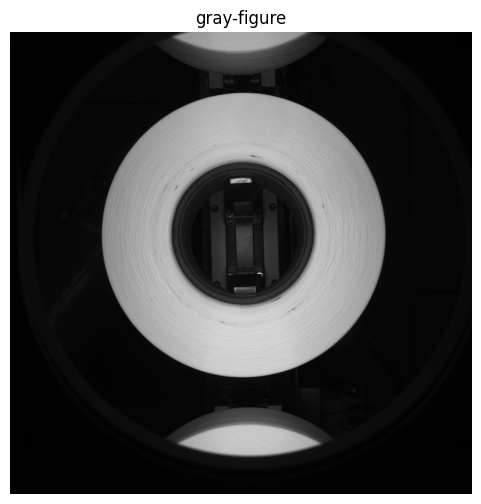

In [235]:
print("当前处理图片：", first_img_path)
img_bgr = cv2.imread(first_img_path, cv2.IMREAD_COLOR)
if img_bgr is None:
    raise RuntimeError("读取图片失败，请检查路径。")

h, w = img_bgr.shape[:2]
print("图像尺寸:", h, "x", w)

# 转为灰度图
img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(6, 6))
plt.imshow(img_gray, cmap="gray")
plt.title("gray-figure")
plt.axis("off")
plt.show()


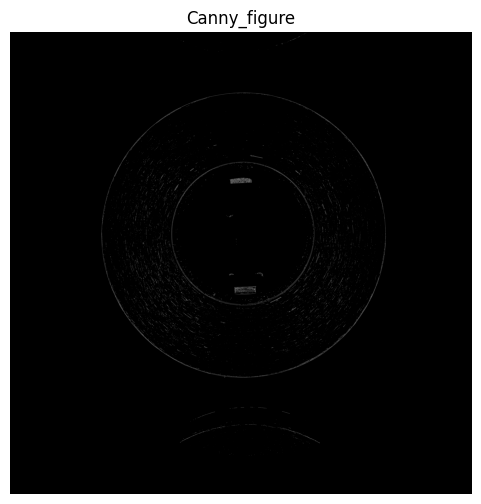

In [236]:
# 用 Canny 做边缘检测（只是看轮廓） 先做一点平滑，减少噪声
blur = cv2.GaussianBlur(img_gray, (5, 5), 0)

# Canny 边缘检测，阈值可以后面再微调
#edges = cv2.Canny(blur, threshold1=20, threshold2=100)
edges = cv2.Canny(img_gray, threshold1=70, threshold2=80)

plt.figure(figsize=(6, 6))
plt.imshow(edges, cmap="gray")
plt.title("Canny_figure")
plt.axis("off")
plt.show()


In [237]:
# === 使用 Hough 圆分别检测外圆和内圆 ===
h, w = edges.shape[:2]
gray_for_hough = img_gray # 如果要改成用灰度图，就写 img_gray

dp = 1.2
minDist = min(h, w) // 2   # 每次只想要一个圆，设大一点避免重复
param1 = 80
param2 = 40

#检测外圆（半径约 1500 ± 100）
circles_outer_raw = cv2.HoughCircles(
    gray_for_hough,
    cv2.HOUGH_GRADIENT,
    dp=dp,
    minDist=minDist,
    param1=param1,
    param2=param2,
    minRadius=1400,   # 1500 - 100
    maxRadius=1600    # 1500 + 100
)

outer_circle = None
if circles_outer_raw is not None:
    cps_o = np.squeeze(circles_outer_raw, axis=0).astype(np.float32)  # (N,3)
    # 选一个半径最接近 1500 的作为外圆
    idx_o = np.argmin(np.abs(cps_o[:, 2] - 1500))
    xo, yo, ro = cps_o[idx_o]
    outer_circle = (xo, yo, ro)
    print("检测到外圆候选个数:", len(cps_o))
    print("外圆(初始):", outer_circle)
else:
    print("没有检测到外圆，请调整外圆的 Hough 参数。")

# 检测内圆（半径约 800 ± 50）
circles_inner_raw = cv2.HoughCircles(
    gray_for_hough,
    cv2.HOUGH_GRADIENT,
    dp=dp,
    minDist=minDist,
    param1=param1,
    param2=param2,
    minRadius=750,    # 800 - 50
    maxRadius=850     # 800 + 50
)

inner_circle = None
if circles_inner_raw is not None:
    cps_i = np.squeeze(circles_inner_raw, axis=0).astype(np.float32)
    # 选一个半径最接近 800 的作为内圆
    idx_i = np.argmin(np.abs(cps_i[:, 2] - 800))
    xi, yi, ri = cps_i[idx_i]
    inner_circle = (xi, yi, ri)
    print("检测到内圆候选个数:", len(cps_i))
    print("内圆(初始):", inner_circle)
else:
    print("没有检测到内圆，请调整内圆的 Hough 参数。")

# 把检测到的内外圆放进 circles
circles_list = []

if outer_circle is not None:
    xo, yo, ro = outer_circle
    circles_list.append((int(round(xo)), int(round(yo)), int(round(ro))))

if inner_circle is not None:
    xi, yi, ri = inner_circle
    circles_list.append((int(round(xi)), int(round(yi)), int(round(ri))))

if len(circles_list) == 0:
    circles = None
    print("外圆和内圆都未检测到。")
else:
    circles = np.array(circles_list, dtype=np.int32)
    print("最终 circles:")
    print(circles)



检测到外圆候选个数: 1
外圆(初始): (2587.8, 2253.0, 1575.08)
检测到内圆候选个数: 1
内圆(初始): (2580.6, 2232.6, 785.88)
最终 circles:
[[2588 2253 1575]
 [2581 2233  786]]


原图外圆 (x, y, r): 2588 2253 1575
原图内圆 (x, y, r): 2581 2233 786


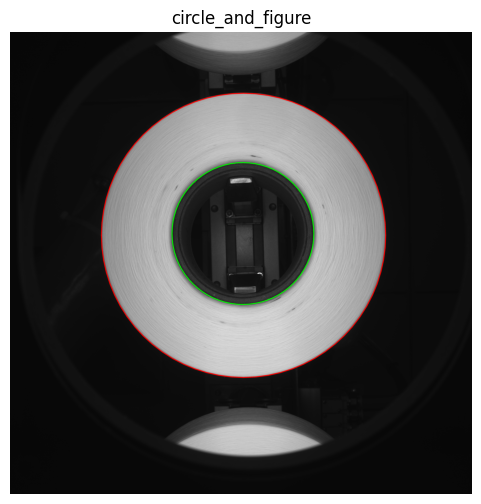

In [238]:
if circles is None or len(circles) == 0:
    raise RuntimeError("没有检测到任何圆，请检查前面的处理或参数。")

# 按半径从大到小排序
selected_small_sorted = sorted(circles, key=lambda c: c[2], reverse=True)

vis_bgr = img_bgr.copy()
#vis_bgr = edges.copy()

if len(selected_small_sorted) >= 2:
    # 至少有两个圆：最大的认为是外圆，次大的认为是内圆
    (xo_s, yo_s, ro_s), (xi_s, yi_s, ri_s) = selected_small_sorted[:2]

    # 放大回原图坐标系（这里本来就是原图坐标，就直接转 int）
    xo, yo, ro = int(xo_s), int(yo_s), int(ro_s)
    xi, yi, ri = int(xi_s), int(yi_s), int(ri_s)

    print("原图外圆 (x, y, r):", xo, yo, ro)
    print("原图内圆 (x, y, r):", xi, yi, ri)

    # 外圆：红色
    cv2.circle(vis_bgr, (xo, yo), ro, (0, 0, 255), 10)
    # 内圆：绿色
    cv2.circle(vis_bgr, (xi, yi), ri, (0, 255, 0), 10)

elif len(selected_small_sorted) == 1:
    # 只有一个圆：只画这一圈（默认当成外圆）
    (xo_s, yo_s, ro_s) = selected_small_sorted[0]
    xo, yo, ro = int(xo_s), int(yo_s), int(ro_s)

    print("只检测到一个圆，原图圆 (x, y, r):", xo, yo, ro)

    # 只画这个圆（红色）
    cv2.circle(vis_bgr, (xo, yo), ro, (0, 0, 255), 10)

# 显示结果
vis_rgb = cv2.cvtColor(vis_bgr, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6, 6))
plt.imshow(vis_rgb)
plt.title("circle_and_figure")
plt.axis("off")
plt.show()
